## Tutorial Flower - Federated Learning

O tutorial tem o objetivo de comparar o aprendizado de máquina tradicional com o federado. Ele está disponível em: https://colab.research.google.com/github/adap/flower/blob/main/examples/flower-in-30-minutes/tutorial.ipynb#scrollTo=gLucT6KFnIT7

*Configurando o ambiente de aprendizado*

In [1]:
# instalo flower (framework para aprendizado federado), matplotlib e pytorch
%pip install -q "flwr[simulation]" flwr-datasets
%pip install matplotlib
%pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


# Treinamento centralizado: a maneira antiga de se fazer ML

Para ilustrar as diferenças entre a maneira tradicional de se fazer aprendizado de máquina e a forma federada, primeiro vamos criar um modelo típico de CNN, com um loop de treino.

In [2]:
# importação das bibliotecas necessárias para o dataset
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset

def get_mnist_dataloaders(mnist_dataset, batch_size : int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # preparo as funções de transformação
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch
    
    mnist_train = mnist_dataset["train"].with_transform(apply_transforms)
    mnist_test = mnist_dataset["test"].with_transform(apply_transforms)

    # construo os dataloaders do pytorch
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle = True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader

# faz o download do conjuento de dados
mnist = load_dataset("ylecun/mnist")

In [3]:
# visão rápida do conjunto de dados
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

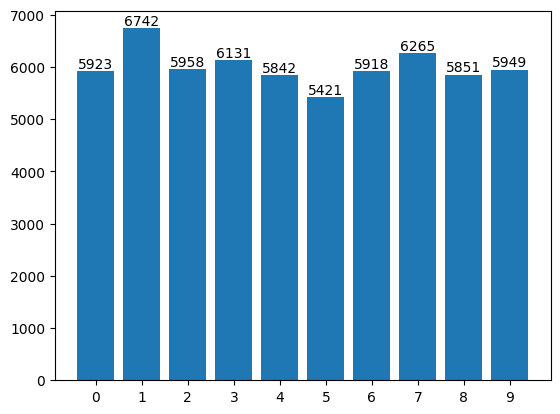

In [4]:
# visualizo a distribuição dos dados de treino por meio de um histograma
import matplotlib.pyplot as plt
from collections import Counter

# construo o histograma
all_labels = mnist["train"]["label"]
all_labels_counts = Counter(all_labels)

# visualizo o histograma
bar = plt.bar(all_labels_counts.keys(), all_labels_counts.values())
_ = plt.bar_label(bar)

# formação da plotagem
_ = plt.xticks([label for label in all_labels_counts.keys()])


will display images with idx: [36959, 35239, 43986, 57364, 15436, 27516, 45884, 27050, 41169, 16233, 36730, 59044, 34271, 16183, 18683, 38880, 30459, 34760, 25881, 50223, 15464, 26632, 44386, 31317, 30109, 4142, 13278, 48267, 12568, 51816, 42313, 27220]


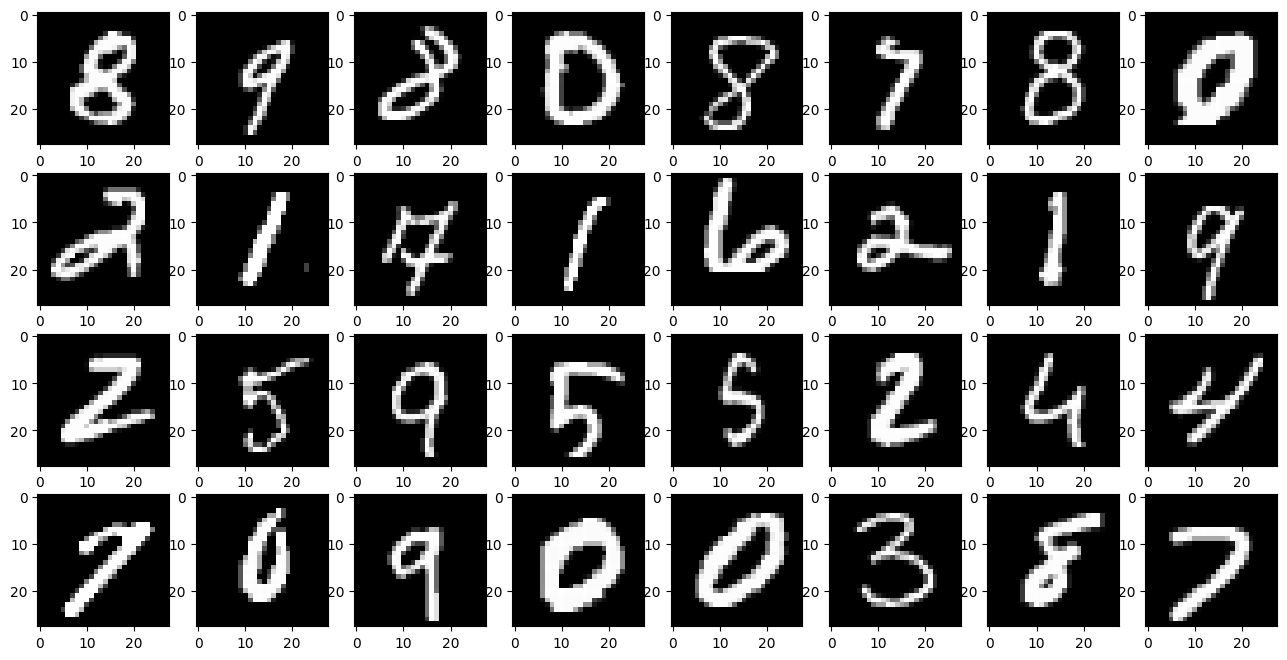

In [5]:
# visualizo 32 imagens do conjunto de dados
import random
import numpy as np
from PIL import Image
import io

def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
  trainset_data = [Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]] # consigo as imagens
  idx = list(range(len(trainset_data))) # crio uma lista de índices em order crescente com base no tamanho do meu conjunto de dados de treino
  random.shuffle(idx) # embaralho os índices da lista
  idx = idx[:n] # pego os primeiros n índices da lista embaralhada
  if verbose:
    print(f"will display images with idx: {idx}")

  # construo o quadro que será utilizado para imprimir as imagens
  num_cols = 8
  num_rows = int(np.ceil(len(idx) / num_cols))
  fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

  # exibo as imagens no quadro
  for c_i, i in enumerate(idx):
    axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

visualise_n_random_examples(mnist["train"], n=32)

*Uma arquitetura CNN*

Uma arquitetura CNN típica é usada para ilustrar a diferença entre a maneira tradicinal e a federada de se fazer aprendizado de máquina.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# modelo da rede neural convolucional a ser usado como base para a comparação
class Net(nn.Module):
  def __init__(self, num_classes: int) -> None:
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear( 16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [7]:
model = Net(num_classes=10) # inicializa o modelo com 10 classes de saída
num_parameters = sum(value.numel() for value in model.state_dict().values()) # soma o número de elementos em cada tensor dos parâmetros (pesos e vieses) do modelo
print(f"{num_parameters = }")

num_parameters = 44426


*O loop de treino*

In [8]:
# defino as funções de treino, teste e a que irá rodar o modelo

def train (net, trainloader, optimizer, device="cpu"):
  """Treino o modelo nos dados de treino"""
  criterion = torch.nn.CrossEntropyLoss() # loss function -> calcula a diferença entre a predição do modelo com o resultado dos dados reais
  net.to(device) # envio o modelo para o dispositivo desejado
  net.train() # coloco o modelo em modo de treino
  for batch in trainloader:
    images, labels = batch["image"].to(device), batch["label"].to(device)
    optimizer.zero_grad()
    loss = criterion(net(images), labels)
    loss.backward()
    optimizer.step()

def test(net, testloader, device):
  """Validação da rede neutral com base no conjunto de dados de teste"""
  criterion = torch.nn.CrossEntropyLoss()
  correct, loss = 0, 0
  net.to(device)
  net.eval()
  with torch.no_grad():
    for batch in testloader:
      images, labels = batch["image"].to(device), batch["label"].to(device)
      outputs = net(images)
      loss += criterion(outputs, labels).item()
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
  accuracy = correct / len(testloader.dataset)
  return loss, accuracy

def run_centralised(trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9):
  # Um loop de treino centralizado completo

  # instanciação do modelo
  model = Net(num_classes=10)

  # descoberta de qual dispositivo está disponível e envio do modelo para lá
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # definição do otimizador juntamente com os hiperparâmetros
  optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

  # loop de treino
  for epoch in range(epochs):
    print(f"Training epoch {epoch} ...")
    train(model, trainloader, optim, device)

  # o treino está completo, então avalia-se o modelo no conjunto de teste
  loss, accuracy = test(model, testloader, device)
  print(f"{loss =}")
  print(f"{accuracy =}")

In [9]:
# construção dos dataloaders
trainloader, testloader = get_mnist_dataloaders(mnist, batch_size=32)

# rodo o treinamento centralizado
run_centralised(trainloader, testloader, epochs=3, lr=0.01)

Training epoch 0 ...
Training epoch 1 ...
Training epoch 2 ...
loss =10.779221353732282
accuracy =0.9891


No treinamento centralizado, a CNN alcançou 0.987% de acurácia, o que já era esperado. Apesar de tal forma de treinamento ser muito útil em várias aplicações, em algumas ela deixa a desejar em ambientes em que não se é possível coletar os dados para se criar um ambiente centralizado de aprendizado.

# O futuro da IA é federado

No aprendizado federado, os dados de cada cliente permanecem privados e o treinamento ocorre de forma distribuída.

Agora, iremos modificar o loop de treino tradicional que fizemos para construir uma pipeline federada de aprendizado.

*Um cliente, uma partição dos dados*

In [10]:
# para rodar o treinamento federado, é necessário importar o flower e dividir os dados entre os clientes de forma aleatória, para simular um ambiente real
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 100 # quantidade de clientes

partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS) # cria um particionador que divide os dados em 100 partes aleatórias e IID
# com base nessa partição aleatória em 100 partes, o conjunto de dados MNIST, na seção de treino, é dividido entre si
fds = FederatedDataset(dataset="ylecun/mnist", partitioners={"train": partitioner})

In [11]:
# para acessar os dados de um cliente específico, basta acessar o índice desejado
partition_0 = fds.load_partition(0)
partition_0

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

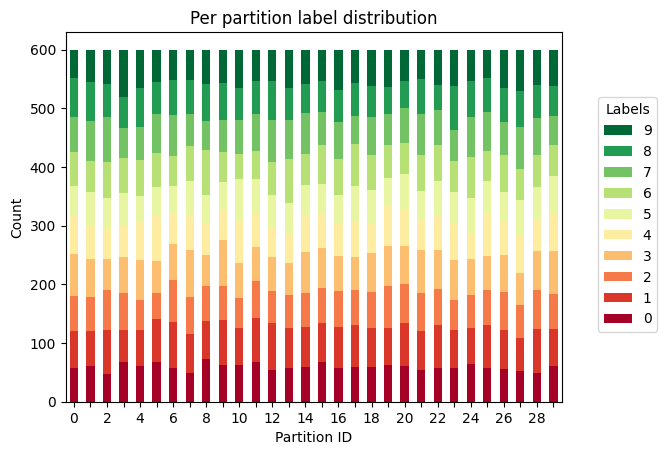

In [12]:
# para visualizar como os dados estão particionados entre os clientes, é interessante plotar um gráfico comparando a distribuição dos dados de treino entre os clientes
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30, # apenas os 30 primeiros clientes são exibidos
    title="Per partition label distribution"
)

*Definindo um cliente no aprendizado federado*

Um cliente em FL é uma entidade que possui alguns dados e treina o modelo utilizando-os. Um cliente flower é uma classe em Python que possui dois métodos distintos:
> fit(): com esse método, o cliente treina o modelo localmente por um determinado número de épocas, utilizando os próprios dados. No final, o modelo resultante é enviado de volta ao servidor para agregação

> evaluate(): com esse método, o server consegue avaliar a performance do modelo global com base no conjunto de validação local de um cliente. Isso pode ser usado, por exemplo, quando não há um dataset centralizado no servidor para validação/teste. Além disso, esse método pode ser usado para avaliar o grau de personalização do modelo federado (isto é, o quão parecido o modelo global está daquele modelo loval)

O nome da classe de clientes flower aqui é FlowerClient. Cada cliente no sistema de aprendizado federado é representado por uma instância de FlowerClient*. Essa classe será futuramente envolta em um uma classe chamada ClientApp (própria do Flower), que lida com a lógica do treinamento por parte do cliente* (*referência: <https://www.kaggle.com/code/nechbamohammed/the-flower-federated-learning-tutorial-part-1>)

In [13]:
from collections import OrderedDict
from typing import Dict

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient
import torch.optim.sgd

# cada cliente flower possui um modelo, os dados de treino e teste particionados em batches, e o dispositivo definido
# além disso, possui as funções de treino e teste, que são as mesmas do treinamento centralizado
class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10) # para treinar o modelo nos clientes, é necessário instanciar a CNN normalmente
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # descobrir qual dispositivo está disponível

    def fit(self, parameters, config): # mesma função de treino do treinamento centralizado
        """ Esse método treina o modelo nos dados locais, com base nos parâmetros enviados pelo servidor.
        No final, os parÂmetros do modelo local treinado são enviados de volta ao servidor"""

        # copia os parâmetros do servidor para o modelo local
        set_params(self.model, parameters)

        # define o optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # treina o modelo local (uso a mesma função do treino centralizado)
        train(self.model, self.trainloader, optim, self.device)

        # retorna os parâmetros do modelo treinado, junto com a quanrtidade de exemplos usados no treino
        return get_params(self.model), len(self.trainloader), {}
    
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]): # mesma função de teste do treinamento centralizado
        """Esse método avalia o modelo nos dados locais de validação, com base nos parâmetros enviados pelo servidor"""

        set_params(self.model, parameters) # mudança dos parâmetros do modelo local para os parâmetros do servidor

        # avalia o modelo local (uso a mesma função de teste)
        loss, accuracy = test(self.model, self.valloader, self.device)

        # retorna a loss e a acurácia do modelo local para o servidor
        return float(loss), len(self.valloader), {"accuracy": accuracy}
    
# Duas funções auxiliares para configurar e extrair os parâmetros do modelo
def set_params(model, parameters):
    """ Troca os parâmetros do modelo local pelo conjunto de parâmetros enviado pelo servidor"""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict) # troco os parâmetros

def get_params(model):
    """ Extraio os parâmetros do modelo local como uma lista de NumPy arrays"""    
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


As instâncias de FlowerClient são criadas pelo Flower à medida em que são necessárias na parte de treinamento e testagem. (https://www.kaggle.com/code/nechbamohammed/the-flower-federated-learning-tutorial-part-1)

*O callback de client_fn*

Para simular uma organização com a sua própria partição dos dados, usa-se a função chamada client_fn. Essa função cria instâncias de FlowerClient de acordo com a necessidade e usa a variável partition_id para carregar partições específicas dos dados em cada cliente (https://www.kaggle.com/code/nechbamohammed/the-flower-federated-learning-tutorial-part-1)

In [14]:
from flwr.common import Context
from flwr.client import ClientApp

def client_fn(context: Context):
    """ Retorna uma instância de FlowerClient, representando um único cliente, contendo a sua partição dos dados """

    partition_id = int(context.node_config["partition-id"])
    partition = fds.load_partition(partition_id, "train")
    # partição entre dados de treino e validação
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)

    # construção dos dataloaders a partir da partição feita entre treino e validação para um único cliente
    trainloader, testloader = get_mnist_dataloaders(partition_train_val, batch_size=32)

    return FlowerClient(trainloader=trainloader, testloader= testloader).to_client() # passagem dos parâmetros para o método __init__ de FlowerClient, contendo os dados de treino e teste particionados em batches referentes a um único cliente

# construção do ClientApp, com base na função client_fn. Essa função é chamada para cada cliente que se conecta ao servidor
client_app = ClientApp(client_fn=client_fn)

### Definindo um ServerApp no Flower



*Definição da estratégia de agregação*
Se na parte do ClientApp definimos como ocorrerá a partição dos dados, na parte do ServerApp estabelecemos como se dará a estratégia de agregação deles. Aqui, utilizaremos a estratégia de Federated Averaging (FedAvg)

In [15]:
from typing import List, Tuple
from flwr.common import Metrics

# definição da métrica da função de agregação
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # multiplicação da acurácia de cada cliente pelo número de exemplos usados
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # agregação e retorno das métrica customizada (média ponderada)
    return {"accuracy": sum(accuracies) / sum(examples)}

*O callback de server_fn*

A classe estabelece o que acontecerá por parte do servidor quando um cliente se conectar a ele. Aqui, ela utiliza a função server_fn como base para as suas operações.


In [16]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 5

def server_fn(context: Context):

    # instancio o modelo feito no treinamento centralizado, já que essa parte de construção de modelos não muda no treinamento federado
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # converto os parâmetros do modelo (em NumPy) para o formato do Flower
    global_model_init = ndarrays_to_parameters(ndarrays)

    # definição da estatrégia 
    strategy = FedAvg(
        fraction_fit=0.1, # tamanho da amostra de clientes que serão usados para rodar o método fit() - treino
        fraction_evaluate=0.5, # tamanho da amostra de clientes que serão usados para rodar o método evaluate() - validação
        evaluate_metrics_aggregation_fn=weighted_average, # função de agregação das métricas definida anteriormente
        initial_parameters=global_model_init # modelo global inicial
    )

    # construção do ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # coloco tudo dentro de um objeto ServerAppComponents -> não preciso passar o modelo como parâmetro, pois ele não será usado, apenas os parâmetros que ele gera são usados no cálculo do FedAvg
    return ServerAppComponents(strategy=strategy, config=config)

# construção do ServerApp, com base na função server_fn. Essa função é chamada para cada cliente que se conecta ao servidor
server_app = ServerApp(server_fn=server_fn)

### Lançamento da simulação

Como as classes ClientApp e ServerApp foram definidas, nós podemos lançar a simulação de um treinamento em ambiente federado. Para tal, basta passar essas classes para a função run_simulation(), juntamente com a quantidade de supernodes/clientes do treinamento.

In [17]:
%pip install -U "flwr[simulation]"

/usr/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=12430) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [18]:
from flwr.simulation import run_simulation

run_simulation(server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.17.171.38, ID: 64d87046967990bc37bdccb06ec149c58fc443b88fad61eda031e313) where the task (actor ID: 9c05f60a472015bd5a73395c01000000, name=ClientAppActor.__init__, pid=13000, memory used=0.42GB) was running was 3.59GB / 3.77GB (0.95051), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 0b16e0f3c04a669936f2ea090868fc3cc7555607b40286b50c3c9d68) because it was the most recently scheduled task; to see more info